# Выбор локации для скважины

Задача проекта:

На основе данных о пробах нефти в трех регионах (в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов) построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.

Основные шаги:

- Загрузка библиотек;
- Открытие файлов и знакомство с данными;
- Предобработка данных;
- Разделение на выборки;
- Обучение модели линейной регрессии и рассчет RMSE;
- Рассчет безубыточной разработки скважины;
- Расчет прибыли и рисков, формулирование общего вывода.

## Загрузка и подготовка данных
### Загрузка библиотек

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### Открытие файлов

In [2]:
tqdm.pandas()

data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [3]:
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [4]:
data_2 = pd.read_csv('/datasets/geo_data_2.csv')
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


### Описание данных

В трех таблицах содержатся данные геологоразведки трёх регионов.

Названия столбцов:

- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек (неважно, что они означают, но сами признаки значимы);
- product — объём запасов в скважине (тыс. баррелей).

### Знакомство с данными

In [5]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [6]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [7]:
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


In [8]:
data_0.duplicated().sum()

0

In [9]:
data_1.duplicated().sum()

0

In [10]:
data_2.duplicated().sum()

0

In [11]:
data_0.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


In [12]:
data_1.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


In [13]:
data_2.describe()

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


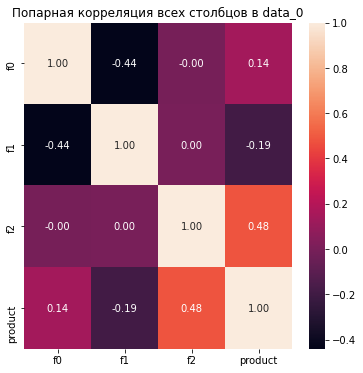

In [14]:
plt.figure(figsize=(6,6))
sns.heatmap(data_0.corr(), annot=True, fmt='.2f'); 
plt.title('Попарная корреляция всех столбцов в data_0');

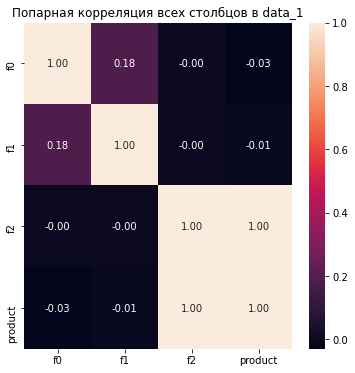

In [15]:
plt.figure(figsize=(6,6))
sns.heatmap(data_1.corr(), annot=True, fmt='.2f');
plt.title('Попарная корреляция всех столбцов в data_1');

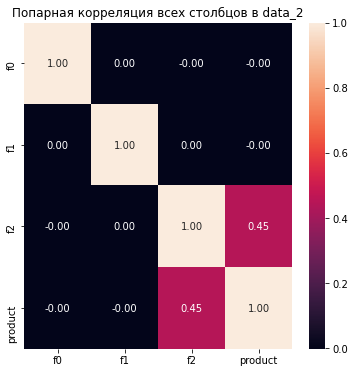

In [16]:
plt.figure(figsize=(6,6))
sns.heatmap(data_2.corr(), annot=True, fmt='.2f');
plt.title('Попарная корреляция всех столбцов в data_2');

### Вывод

- В каждой из  таблиц - 100 тыс. строк.
- Столбец id имеет тип object, остальные - float64.
- Дубликаты отсутствуют.
- Данные в столбцах f0, f1, f2 почти не отличаются по масштабу, поэтому масштабирование не потребуется.
- Столбец id помешает обучению модели, на этапе предобработки его необходимо удалить.
- В таблице data_1 наблюдается очень высокая положительная корреляция между столбцами f2 и product.
- В таблицах  data_0 и data_2 наблюдается средняя положительная корреляция между столбцами f2 и product.
- В таблице data_0 наблюдается средняя отрицательная корреляция между столбцами f0 и f1.
- В регионе 2 объём запасов в скважинах максимальный, в регионе 1 - минимальный. В регионе 0 - объем близок к максимальному.

### Предобработка данных

In [17]:
data_0 = data_0.drop('id', 1)
data_1 = data_1.drop('id', 1)
data_2 = data_2.drop('id', 1)
display(data_0.shape)
display(data_1.shape)
data_2.shape

(100000, 4)

(100000, 4)

(100000, 4)

### Разделение данных на выборки

In [18]:
data_train_0, data_valid_0 = train_test_split(data_0, test_size=0.25, random_state=12345)
data_train_1, data_valid_1 = train_test_split(data_1, test_size=0.25, random_state=12345)
data_train_2, data_valid_2 = train_test_split(data_2, test_size=0.25, random_state=12345)

display(data_train_0.shape)
display(data_valid_0.shape)
display(data_train_1.shape)
display(data_valid_1.shape)
display(data_train_2.shape)
data_valid_2.shape

(75000, 4)

(25000, 4)

(75000, 4)

(25000, 4)

(75000, 4)

(25000, 4)

### Вывод

Файлы загружены и подготовлены к обучению модели.

## Обучение и проверка модели
### Обучение модели

In [19]:
features_train_0 = data_train_0.drop(['product'],axis=1)
target_train_0 = data_train_0['product']

features_valid_0 = data_valid_0.drop(['product'],axis=1)
target_valid_0 = data_valid_0['product']

features_train_1 = data_train_1.drop(['product'],axis=1)
target_train_1 = data_train_1['product']

features_valid_1 = data_valid_1.drop(['product'],axis=1)
target_valid_1 = data_valid_1['product']

features_train_2 = data_train_2.drop(['product'],axis=1)
target_train_2 = data_train_2['product']

features_valid_2 = data_valid_2.drop(['product'],axis=1)
target_valid_2 = data_valid_2['product']

In [20]:
model_0 = LinearRegression()
model_0.fit(features_train_0, target_train_0)
answer_0 = model_0.predict(features_valid_0)
rmse_0 = mean_squared_error(target_valid_0, answer_0) ** 0.5 

print('Cредний запас предсказанного сырья для региона 0:', answer_0.mean())
print('RMSE модели для региона 0:', rmse_0)

Cредний запас предсказанного сырья для региона 0: 92.59256778438035
RMSE модели для региона 0: 37.5794217150813


In [21]:
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
answer_1 = model_1.predict(features_valid_1)
rmse_1 = mean_squared_error(target_valid_1, answer_1) ** 0.5 

print('Cредний запас предсказанного сырья для региона 1:', answer_1.mean())
print('RMSE модели для региона 1:', rmse_1)

Cредний запас предсказанного сырья для региона 1: 68.728546895446
RMSE модели для региона 1: 0.893099286775617


In [22]:
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
answer_2 = model_2.predict(features_valid_2)
rmse_2 = mean_squared_error(target_valid_2, answer_2) ** 0.5 

print('Cредний запас предсказанного сырья для региона 1:', answer_2.mean())
print('RMSE модели для региона 1:', rmse_2)

Cредний запас предсказанного сырья для региона 1: 94.96504596800489
RMSE модели для региона 1: 40.02970873393434


### Вывод

In [23]:
df = pd.DataFrame({'Регион': ['0', '1', '2'], 'Cредний запас предсказанного сырья': [answer_0.mean(), answer_1.mean(), answer_2.mean()], 'RMSE модели': [rmse_0, rmse_1, rmse_2]})
df

,Регион,Cредний запас предсказанного сырья,RMSE модели
0,0,92.592568,37.579422
1,1,68.728547,0.893099
2,2,94.965046,40.029709


Самая высокая точность модели для региона 1 (RMSE модели: 0.89) при самом низком среднем запасе предсказанного сырья 68.72 тыс. баррелей.

Показатели моделей для регионов 0 и 2 незначительно отличаются между собой (RMSE: 37.57, запас: 92.59 тыс. баррелей; RMSE: 40.02, запас: 94.96 тыс. баррелей). С увеличением среднего запаса предсказанного сырья увеличивается и корень средней квадратичной ошибки.

## Подготовка к расчёту прибыли
### Введение новых переменных

In [24]:
n_borehole = 500
n_best_borehole = 200
budget = 10000000000
income = 450000
loss = 0.025

### Рассчет безубыточной разработки скважины

In [25]:
n_borehole_null = budget/income/n_best_borehole
n_borehole_null

111.11111111111111

### Вывод

При озвученных данных разработка может считаться безубыточной при обнаружении в ней запаса в 111.11 тыс. баррелей нефти. Этот показатель выше, чем средние запасы предсказанного сырья для всех трех регионов.

На первый взгляд добиться безубыточности легче в регионах 0 и 2. Проверим эту гипотезу в последующих шагах.

## Расчёт прибыли и рисков 

### Bootstrap

In [26]:
def profit(target, answer):
    
    profit = 0
    answers_sort = answer.sort_values(ascending=False).head(n_best_borehole)
    target_sort = target[answers_sort.index][:n_best_borehole]
    
    for raw in target_sort:
        profit += (raw - n_borehole_null)*income
        
    return profit

In [27]:
def bootstrap(target, answer):
    
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(1000):
        target_subsample = target.sample(n=n_borehole, replace=True, random_state=state)
        probs_subsample = (pd.Series(answer,index=target.index))[target_subsample.index] 
        values.append(profit(target_subsample, probs_subsample))

    values = pd.Series(values)
    lower = values.quantile(0.025)/1000000
    upper = values.quantile(0.975)/1000000
    mean = values.mean()/1000000
    risk = (values < 0).mean()

    
    print(f'Средняя прибыль: {mean:.2f} млн. руб.')
    print(f'95%-й доверительный интервал: от {lower:.2f} до {upper:.2f} млн. руб.')
    print(f'Риск убытков: {risk:.1%}')

In [28]:
print('Регион 0:')
print(bootstrap(target_valid_0, answer_0))

Регион 0:
Средняя прибыль: 425.94 млн. руб.
95%-й доверительный интервал: от -102.09 до 947.98 млн. руб.
Риск убытков: 6.0%
None


In [29]:
print('Регион 1:')
print(bootstrap(target_valid_1, answer_1))

Регион 1:
Средняя прибыль: 515.22 млн. руб.
95%-й доверительный интервал: от 68.87 до 931.55 млн. руб.
Риск убытков: 1.0%
None


In [30]:
print('Регион 2:')
print(bootstrap(target_valid_2, answer_2))

Регион 2:
Средняя прибыль: 435.01 млн. руб.
95%-й доверительный интервал: от -128.88 до 969.71 млн. руб.
Риск убытков: 6.4%
None


### Вывод

Регион 0 для разработки новых скважин является убыточным (средняя прибыль: -1727.07 млн. руб.). Регионы 1 и 2 являются прибыльными (515.22 млн. руб. и 435.01 млн. руб.). Однако риск убытков у 1 региона ниже (1.0%) и в 95%-ом доверительном интервале присутствуют только положительные значения (а значит разработка большинства скважин будет прибыльной). Риск убытков в регионе 2 выше (6.4%), а в 95%-ом доверительном интервале присутствуют отрицательные числа, поэтому часть разработки скважин будут убыточными.

## Общий вывод

Регион 1 принесёт наибольшую прибыль при разработке скважин. Для этого региона была построена самая точная модель (RMSE модели: 0.89). При самом низком среднем запасе предсказанного сырья в этом регионе (68.72 тыс. баррелей) предсказана самая высокая средняя прибыль (515.22 млн. руб.), а риск убытков у этого региона самый низкий (1.0%). В 95%-ом доверительном интервале присутствуют только положительные значения (значит разработка большинства скважин будет прибыльной).